# `jaxtronomy` starting guide

This notebooks show a basic example of simulating and modeling a lensed source with the auto-differentiable framework, relying on JAX. for computing derivatives w.t.r. to all parameters of interest.

_Some modules such as the one that handles likelihood definitions, are still being developed. This notebookd will thus be updated very soon with new interface elements._


__authors__: @austinpeel, @aymgal

__last updated__: 06/07/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np
from scipy.optimize import minimize
from copy import deepcopy

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import corner

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel
from jaxtronomy.Inference.parameters import Parameters
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image model

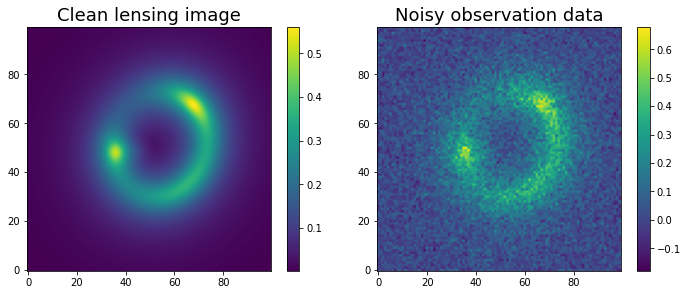

In [6]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
image_model = ImageModel(data_class=pixel_grid,
                         psf_class=psf,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

image = image_model.image(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light,
                          kwargs_ps={})

# Noise
exp_time = 100
sigma_bkd = 0.05
poisson = image_util.add_poisson(image, exp_time)
gaussian = image_util.add_background(image, sigma_bkd)

# Observed noisy data
data = image + gaussian + poisson

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [7]:
# (Don't trust this the first time you run it.)
%timeit image_model.image(kwargs_lens_mass, kwargs_source_light, kwargs_lens_light, kwargs_ps={})

The slowest run took 23.96 times longer than the fastest. This could mean that an intermediate result is being cached.
327 µs ± 510 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Source fitting

### Parameter class

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

In [8]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.2, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 1e-3, 'gamma2': 1e-3}],
    'kwargs_source': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1., 2.], 'e1': ['uniform', -0.5, 0.5], 'e2': ['uniform', -0.5, 0.5], 'center_x': ['uniform', -0.3, 0.3], 'center_y': ['uniform', -0.3, 0.3]}, {'gamma1': ['uniform', -0.5, 0.5], 'gamma2': ['uniform', -0.5, 0.5]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': kwargs_source_light,  # fix all source parameters
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light}
p_true = parameters.kwargs2args(kwargs_true)
param_names = parameters.names
print("truths:", p_true, param_names)

print("prior types:", parameters.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters.bounds)

truths: [ 1.6   0.15 -0.04  0.    0.   -0.01  0.03] ['theta_E', 'e1', 'e2', 'center_x', 'center_y', 'gamma1', 'gamma2']
prior types: ['uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform']
lower/upper bounds (for uniform priors): [ 1.  -0.5 -0.5 -0.3 -0.3 -0.5 -0.5] [2.  0.5 0.5 0.3 0.3 0.5 0.5]


### Loss function

In [9]:
def create_loss_func(data, model, param, noise_var=None):
    """Create a jit-compiled callable loss function.
    
    Parameters
    ----------
    data : 2D array
        Observed image.
    model : instance of a jaxtronomy ImageModel
        ImageModel instance with a callable image() method.
    noise_var : 2D array, optional
        Noise variance per pixel assuming independence, i.e.
        a diagonal covariance matrix.
    
    """
    if noise_var is None:
        noise_var = jnp.ones_like(data)
    assert noise_var.shape == data.shape, "Invalid noise variance map"
    
    def loss_func(kwargs):
        # Compute reconstruction with these parameters
        rec = model.image(**kwargs)
        
        # negative log-likelihood
        loss = 0.5 * jnp.sum((data - rec)**2 / noise_var)
        
        # negative log-prior
        #loss -= param.log_prior(param.kwargs2args(kwargs))
        
        # Other regularisations
        # loss += ...
        
        return loss
    
    return jax.jit(loss_func)

# Create loss and grad(loss) functions of parameter dictionaries
noise_var = jnp.abs(image) / exp_time + gaussian.var()
loss = create_loss_func(data, image_model, parameters, noise_var=noise_var)
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters

In [10]:
loss(kwargs_true)

DeviceArray(5013.56033263, dtype=float64)

In [11]:
grad_loss(kwargs_true)

{'kwargs_lens': [{'center_x': DeviceArray(179.63501005, dtype=float64),
   'center_y': DeviceArray(-108.83661562, dtype=float64),
   'e1': DeviceArray(142.30320274, dtype=float64),
   'e2': DeviceArray(-383.92572203, dtype=float64),
   'theta_E': DeviceArray(31.6752771, dtype=float64)},
  {'dec_0': DeviceArray(3.45621809, dtype=float64),
   'gamma1': DeviceArray(-335.13471024, dtype=float64),
   'gamma2': DeviceArray(841.77363327, dtype=float64),
   'ra_0': DeviceArray(-10.21489034, dtype=float64)}],
 'kwargs_source': [{'R_sersic': DeviceArray(-44.55092421, dtype=float64),
   'amp': DeviceArray(1.02938187, dtype=float64),
   'center_x': DeviceArray(-205.83544613, dtype=float64),
   'center_y': DeviceArray(271.88452921, dtype=float64),
   'n_sersic': DeviceArray(49.81291688, dtype=float64)}]}

### Minimize the loss function over source parameters using scipy

The following method calls `scipy.optimize.mininize`. Supported methods are:
- `'Nelder-Mead'`: uses no analytical gradient;
- `'BFGS'`: uses gradient;
- `'Newton-CG'`/`'trust-krylov'`/`'trust-constr'`: uses gradient and hessian-vector product. In addition, `'trust-constr'` uses bounds from uniform prior consistently within the optimization;
- `'trust-exact'` (uses gradient and hessian).

Setting `use_exact_hessian_if_allowed=True` forces methods that use the hessian-vector product to use the full hessian instead.

In [12]:
# Optimise !
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

Runtime: 10.170960903167725


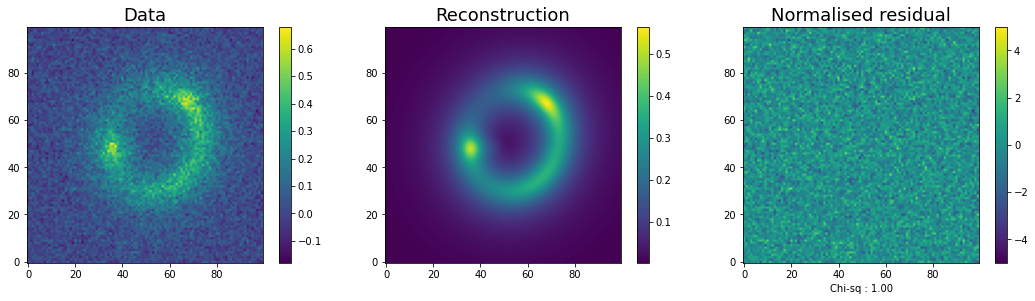

In [13]:
def plot_image_model(kwargs):
    rec = image_model.image(**kwargs)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [14]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} %")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} (abs)")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.03 %
e1:        2.98 %
e2:        -9.01 %
center_x:  0.01 (abs)
center_y:  0.00 (abs)
gamma1:    -8.12 %
gamma2:    8.56 %
ra_0:      0.00 (abs)
dec_0:     0.00 (abs)


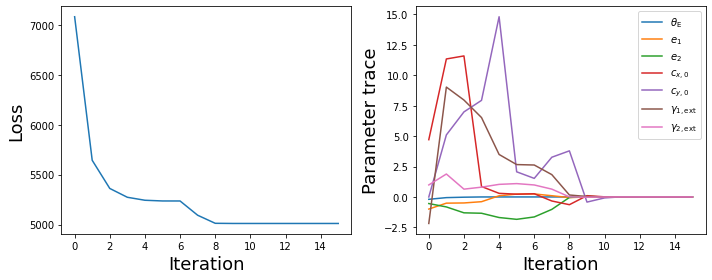

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Fisher matrix & approximated posteriors

Using approximated inverse Hessian


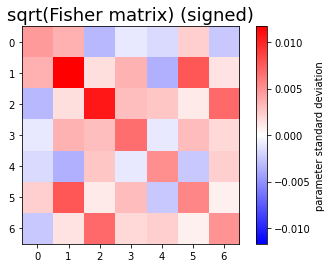

In [16]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
else:
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.colorbar(label="parameter standard deviation")
plt.show()

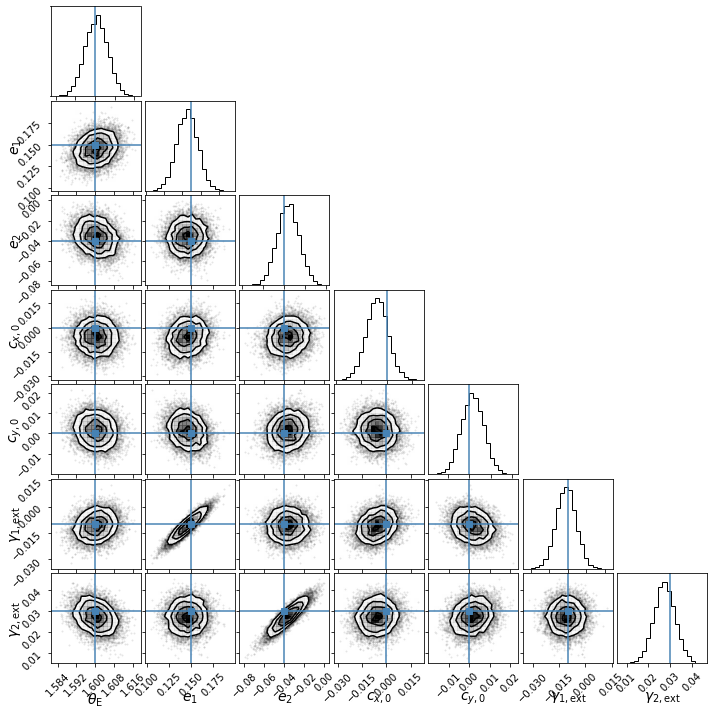

In [17]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(best_fit, fisher_matrix, ndraws=10000)

fig = plt.figure(figsize=(10, 10))
fig = corner.corner(samples_fisher, truths=p_true, show_titles=False, labels=parameters.symbols, 
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

### Compare with PSO

In [18]:
best_fit, logL_pso, extra_fields_pso, runtime \
    = optimizer.pso(n_particles=100, n_iterations=100, restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_pso = deepcopy(parameters.args2kwargs(best_fit))

10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
Runtime: 38.53891682624817


Error
-----
theta_E:   0.03 %
e1:        3.08 %
e2:        -8.89 %
center_x:  0.01 (abs)
center_y:  0.00 (abs)
gamma1:    -8.47 %
gamma2:    8.80 %
ra_0:      0.00 (abs)
dec_0:     0.00 (abs)


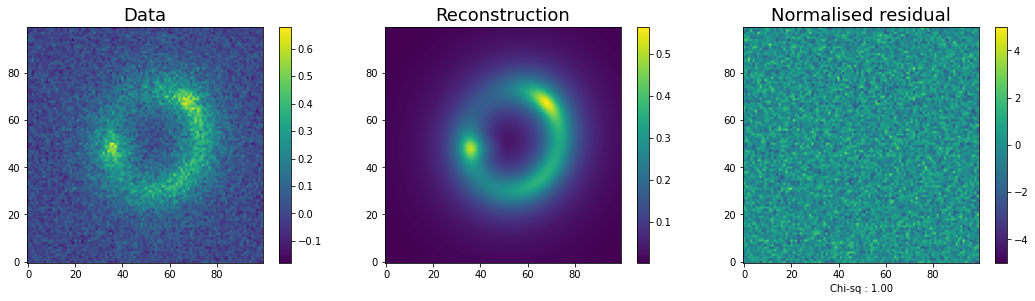

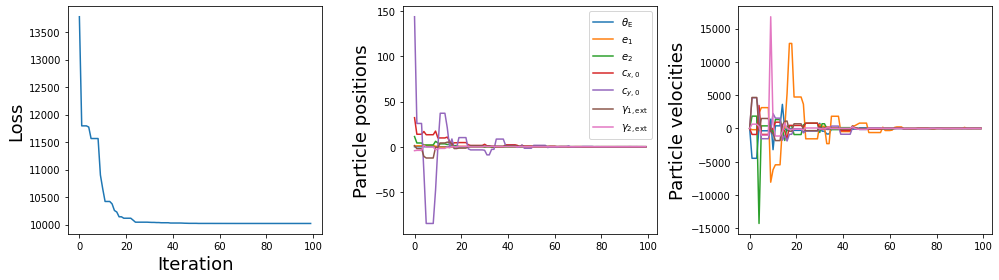

In [19]:
plot_image_model(kwargs_pso)
print_errors(kwargs_pso)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.plot(range(len(extra_fields_pso['chi2_list'])), -np.array(extra_fields_pso['chi2_list']))
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_pos = np.array(extra_fields_pso['pos_list'])
param_vel = np.array(extra_fields_pso['vel_list'])
for i in range(len(param_names)):
    ax.plot(range(len(param_pos)), (param_pos[:, i] - param_pos[-1, i]) / param_pos[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Particle positions", fontsize=FS)
#ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
ax = axes[2]
param_history = np.array(optimizer.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(param_vel)), (param_vel[:, i] - param_vel[-1, i]) / param_vel[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Particle velocities", fontsize=FS)
fig.tight_layout()
plt.show()

## Posterior inference

Previously we found a point-estimate of the maximum _a posteriori_ set of parameters. Thanks to auto-diff, we also accessed a lower bound for uncertaintiy and first-order covariances of each parameters.

We are now interested to compute the underlying full joint posterior over our set of parameters. For this we can run a __Hamiltonian Monte Carlo (HMC)__ that takes advantage of the gradients of the loss function, or a more classical __Markov Chain Monte Carlo (MCMC)__ for comparison.

In [20]:
sampler = Sampler(loss, parameters)

### Hamiltonian Monte Carlo (HMC) with  `numpyro`

In [21]:
samples, logL, extra_fields, runtime = sampler.hmc(num_warmup=100, num_samples=2000, 
                                                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples.shape}")

sample: 100%|██████████| 2100/2100 [06:15<00:00,  5.60it/s, 31 steps of size 1.34e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      1.60      0.00      1.60      1.59      1.61   2094.37      1.00
   Param:1      0.14      0.01      0.14      0.13      0.16    833.75      1.00
   Param:2     -0.04      0.01     -0.04     -0.05     -0.02    807.95      1.00
   Param:3     -0.01      0.01     -0.01     -0.02      0.00   1371.55      1.00
   Param:4      0.00      0.01      0.00     -0.01      0.01   1788.90      1.00
   Param:5     -0.01      0.01     -0.01     -0.02     -0.00    893.75      1.00
   Param:6      0.03      0.00      0.03      0.02      0.04    924.73      1.00

Number of divergences: 0
Runtime: 384.5882489681244
Samples shape: (2000, 7)


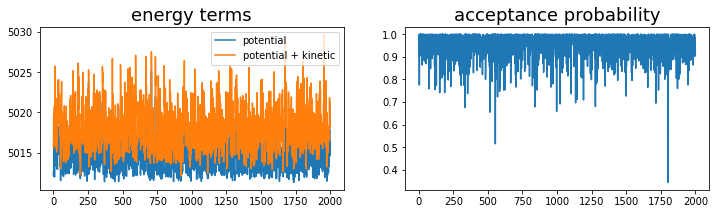

In [22]:
#print(extra_fields.keys())

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.set_title("energy terms", fontsize=FS)
ax.plot(extra_fields['potential_energy'], label="potential")
ax.plot(extra_fields['energy'], label="potential + kinetic")
ax.legend()
ax = axes[1]
ax.set_title("acceptance probability", fontsize=FS)
ax.plot(extra_fields['accept_prob'])
plt.show()

{'kwargs_lens': [{'theta_E': DeviceArray(1.60030354, dtype=float64), 'e1': DeviceArray(0.14465681, dtype=float64), 'e2': DeviceArray(-0.03651783, dtype=float64), 'center_x': DeviceArray(-0.00592102, dtype=float64), 'center_y': DeviceArray(0.00165919, dtype=float64)}, {'gamma1': DeviceArray(-0.01114741, dtype=float64), 'gamma2': DeviceArray(0.02744761, dtype=float64), 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}], 'kwargs_lens_light': []} 5011.014675682551


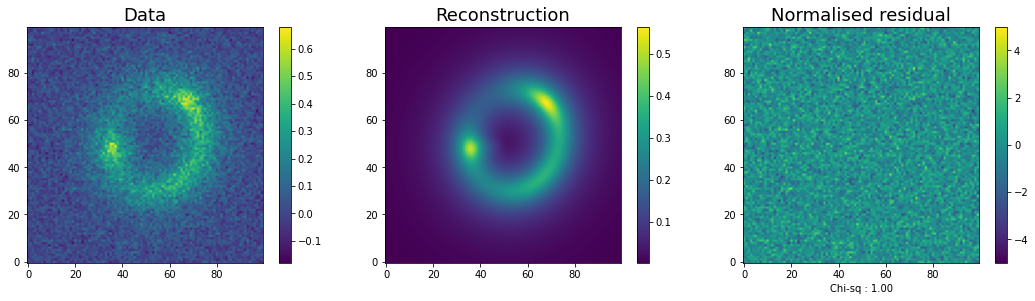

In [23]:
kwargs_posterior = parameters.MAP_values(as_kwargs=True)
print(kwargs_posterior, loss(kwargs_posterior))

plot_image_model(kwargs_posterior)

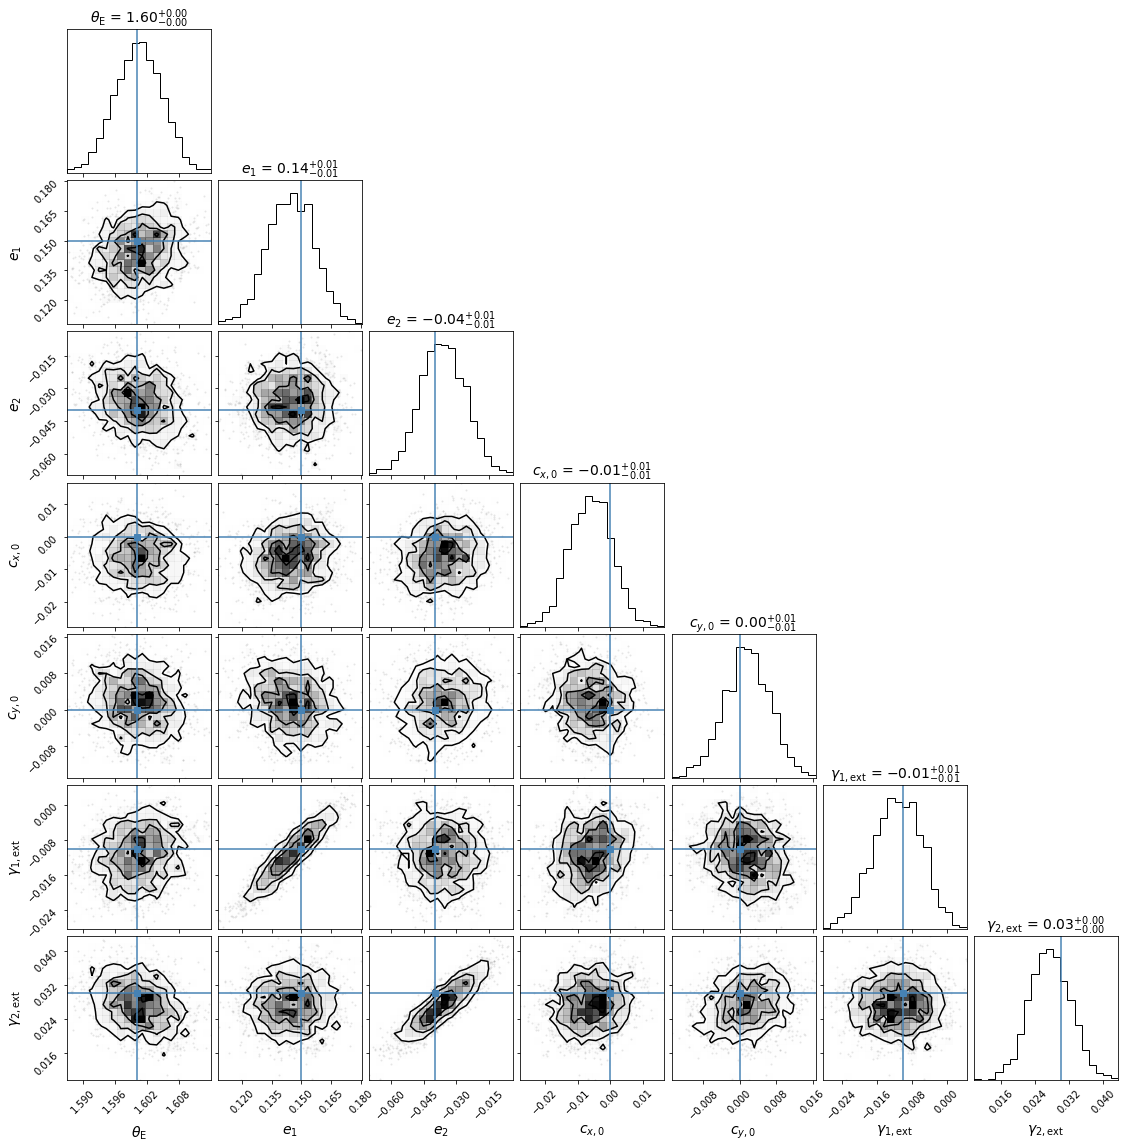

In [24]:
fig = corner.corner(samples, truths=p_true, show_titles=True, 
                    labels=parameters.symbols, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

In [25]:
# compare uncertainties with Fisher information estimates
mcmc_std = samples.std(axis=0)
fisher_std = np.diag(np.sqrt(fisher_matrix))
print("MCMC uncertainties:", mcmc_std)
print("Fisher estimates (lower bound):", fisher_std)

MCMC uncertainties: [0.00449282 0.01166043 0.01058969 0.00642034 0.00506446 0.00550849
 0.00488   ]
Fisher estimates (lower bound): [0.00460324 0.01167995 0.01063267 0.00657061 0.00517629 0.00552729
 0.00495415]


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


### Compare with usual MCMC with `emcee`

Here we run an Ensemble Affine Invariant sampler for MCMC. As `emcee` does not support just-in-time compilation (`jit`) because it needs to `pickle` the log-likelhood function, we need to redefine it here.

In [26]:
# decide on some scatter to initialize emcee walkers
kwargs_std = {
    'kwargs_lens': [{'theta_E': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}],
    'kwargs_source': [{}], 
}
init_stds = parameters.kwargs2args(kwargs_std)

# here we need to define a non-jitted log-likelihood function
def log_likelihood_nojit(args):
    # Compute reconstruction with these parameters
    rec = image_model.image(**parameters.args2kwargs(args))
    # log-likelihood
    #log_l = - 0.5 * jnp.mean((data - rec)**2 / noise_var)
    log_l = - 0.5 * jnp.sum((data - rec)**2 / noise_var)
    # log-prior
    log_l += parameters.log_prior_nojit(args)
    return log_l

samples_mcmc, logL_mcmc, extra_fields_mcmc, runtime \
    = sampler.mcmc(log_likelihood_nojit, init_stds, 
                   walker_ratio=10, num_warmup=100, num_samples=100, 
                   restart_from_init=False)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_mcmc.shape}")

100%|██████████| 200/200 [02:26<00:00,  1.36it/s]

Runtime: 147.45762610435486
Samples shape: (7000, 7)


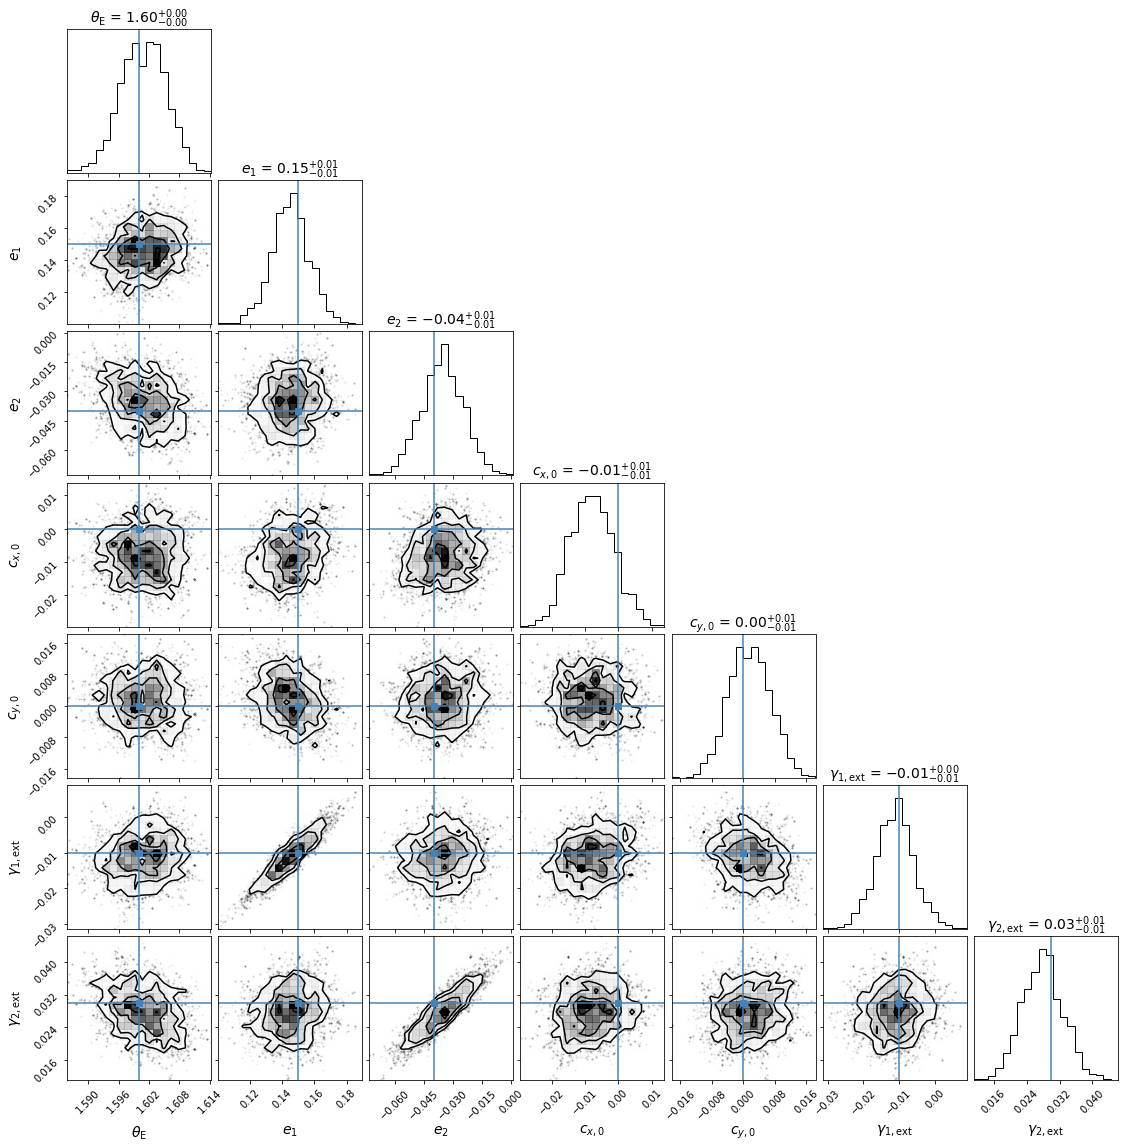

In [27]:
fig = corner.corner(samples_mcmc, truths=p_true, show_titles=True, 
                    labels=parameters.symbols, 
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()